Small Medium Big -> Size Factor를 구해보자

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from statsmodels.api import OLS, add_constant
from scipy.stats import stats

In [2]:
mktcap = pd.read_pickle("ryu_mktcap.pickle")
price  = pd.read_pickle("ryu_price.pickle")

In [12]:
# pct를 구해줌
pct = price.pct_change(fill_method=None)
pct_3days = price.pct_change(3, fill_method=None) \
               .resample("3D").first()
pct_weekly = price.pct_change(7, fill_method=None) \
                  .resample("W").first()

# 시총 weights 계산
mktcap_3days = mktcap.resample("3D").first()
mktcap_weekly = mktcap.resample("W").first()

weight_daily = mktcap.apply(lambda x: x / np.nansum(x), axis=1)
weight_3days = mktcap_3days.apply(lambda x: x/ np.nansum(x), axis=1)
weight_weekly = mktcap_weekly.apply(lambda x: x/ np.nansum(x), axis=1)

# nan처리를 위한 masking 생성
sign_daily = np.sign(price)
sign_3days = np.sign(price.loc[pct_3days.index[:-1]])
sign_weekly = np.sign(price.loc[pct_weekly.index[:-1]])

# masking을 해준 pct_change 데이터프레임을 생성
rtn_daily = sign_daily * pct
rtn_3days = sign_3days * pct_3days
rtn_weekly = sign_weekly * pct_weekly

In [10]:
def draw_return_result(return_df, 
                       freq:str):
    '''return을 주면 결과를 리포트 합니다,
       freq에 Weekly, Daily, 3days 등 넣어줘야함(plot title에 들어감)'''
    fig, axes = plt.subplots(3,1, sharex=True, figsize=(24,24), 
                             gridspec_kw={'height_ratios': [4, 1, 1]})
    cum_df = (return_df+1).cumprod()
    cum_df.plot(ax=axes[0])
    axes[0].set_title("Cummulative {} returns weighted by marketcap".format(freq))
    axes[0].grid()

    peak = cum_df.cummax()
    drawdown = (cum_df - peak)/peak
    drawdown.plot(ax=axes[1])
    axes[1].set_title("Draw Down")
    axes[1].grid()

    return_df.plot(ax=axes[2])
    axes[2].set_title("{} Returns".format(freq))
    axes[2].grid();

def cross_sectional_size_terciles(return_df:pd.DataFrame, 
                                      mktcap_df:pd.DataFrame,
                                      num_of_coin_in_group:int,
                                      return_num = False):
    rtn = return_df.copy()
    mktcap = mktcap_df.copy()
    return_dict = {}
    
    quintile = [1/3, 2/3]
    thresh = mktcap.apply(lambda x: np.nanquantile(x,quintile),
                       axis=1)
    t1 = thresh.apply(lambda x: x[0])
    t2 = thresh.apply(lambda x: x[1])
    
    # Group별로 True/False를 담고 있다 -> Masking에 사용하면 된다
    small = mktcap.apply(lambda x: x <= t1, axis=0) \
                      .replace(True, 1).replace(False, np.nan)
    medium= mktcap.apply(lambda x: (t1 < x) & (x <= t2), axis=0) \
                      .replace(True, 1).replace(False, np.nan)
    big = mktcap.apply(lambda x: t2 < x, axis=0) \
                      .replace(True, 1).replace(False, np.nan)
                      
    # 횡단면 코인 개수가 그룹별로  num_of_coin_in_group이 넘는 날짜를 출력하자                  
    num_coin = pd.concat([small.sum(1), medium.sum(1), big.sum(1)],
                         axis=1)
    
    slice = num_coin[num_coin > num_of_coin_in_group].dropna(axis=0)
    start_date = slice.index[0]
    print("{}에서부터 수익률을 계산".format(start_date))          
            
    # 그룹별로 시가총액 weight를 계산
    weight_1 = (small * mktcap).apply(lambda x: x / np.nansum(x), axis=1)
    weight_2 = (medium* mktcap).apply(lambda x: x / np.nansum(x), axis=1)
    weight_3 = (big * mktcap).apply(lambda x: x / np.nansum(x), axis=1)
    
    rtn1 = ((rtn * weight_1.shift(1)).loc[start_date:].iloc[:-1].sum(1))
    rtn2 = ((rtn * weight_2.shift(1)).loc[start_date:].iloc[:-1].sum(1))
    rtn3 = ((rtn * weight_3.shift(1)).loc[start_date:].iloc[:-1].sum(1))
    
    return_dict["small"] = rtn1 
    return_dict["medium"] = rtn2 
    return_dict["big"] = rtn3 

    if return_num:
        return_dict["count"] = num_coin.loc[start_date:].iloc[:-1]
    return return_dict

In [22]:
size_result = cross_sectional_size_terciles(rtn_daily, mktcap,
                                            19, True)

c:\Users\user\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1374: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(


2017-03-07 00:00:00에서부터 수익률을 계산


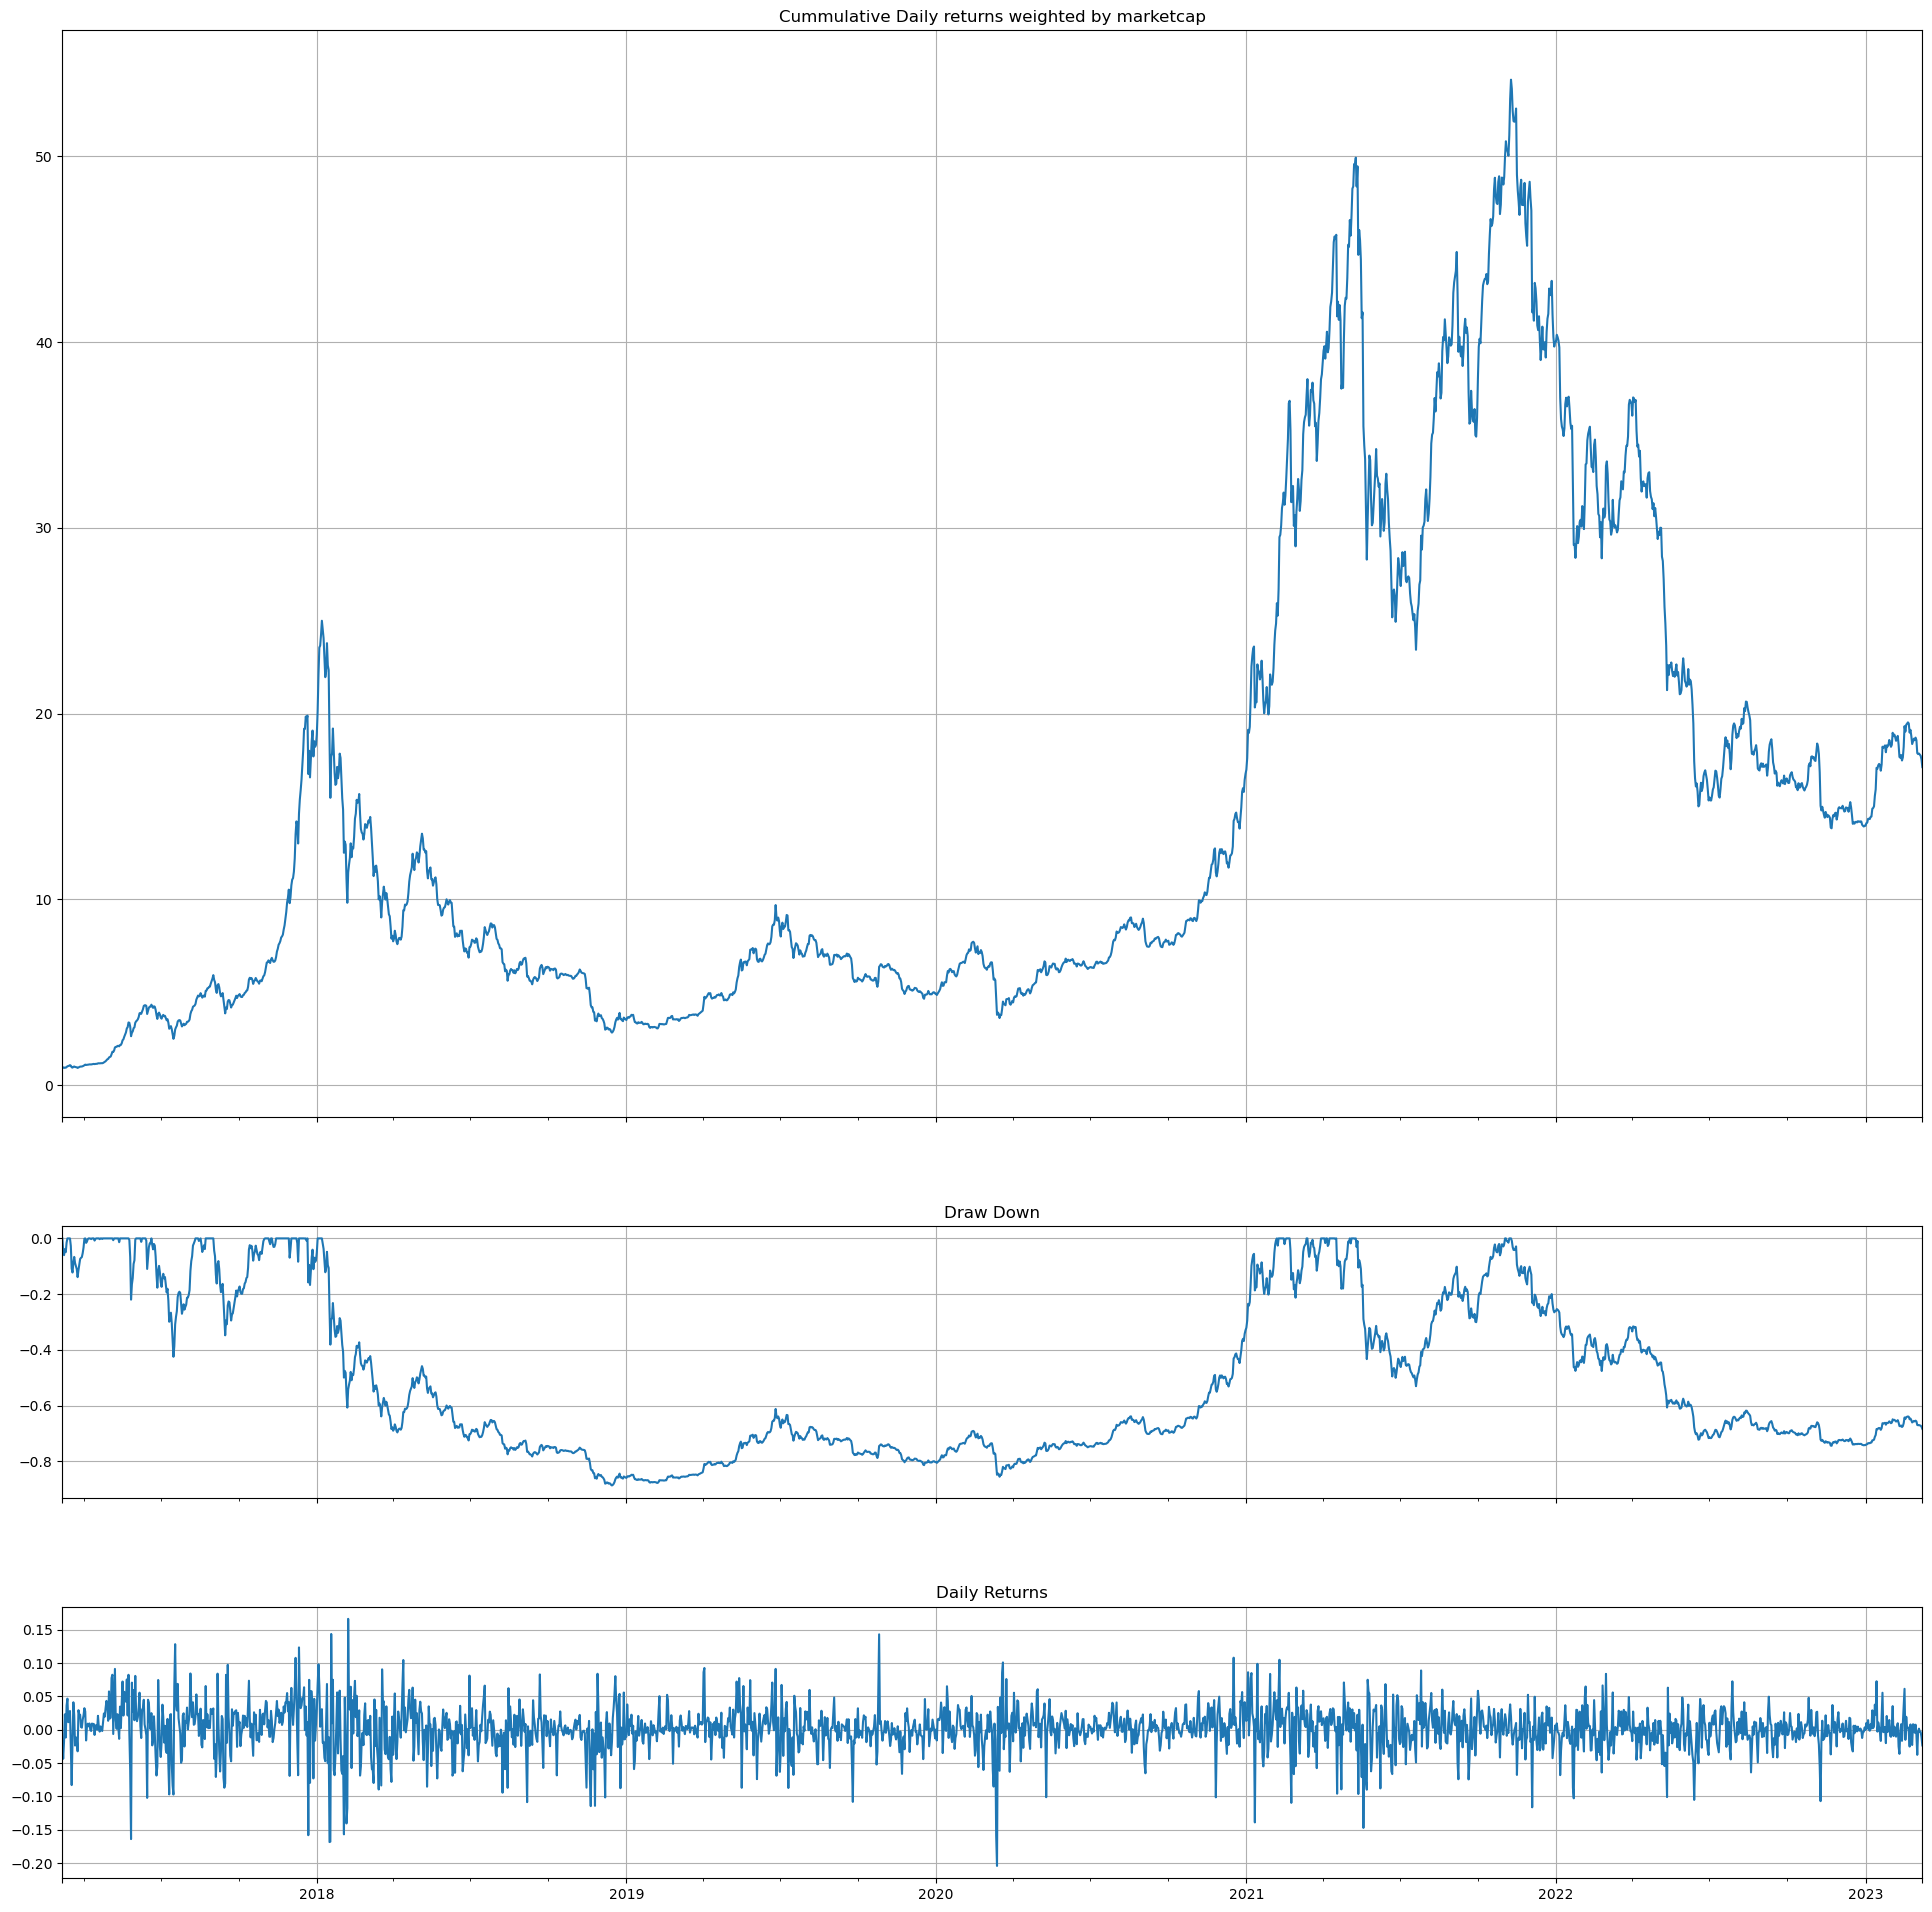

In [27]:
draw_return_result(size_result["big"], "Daily")

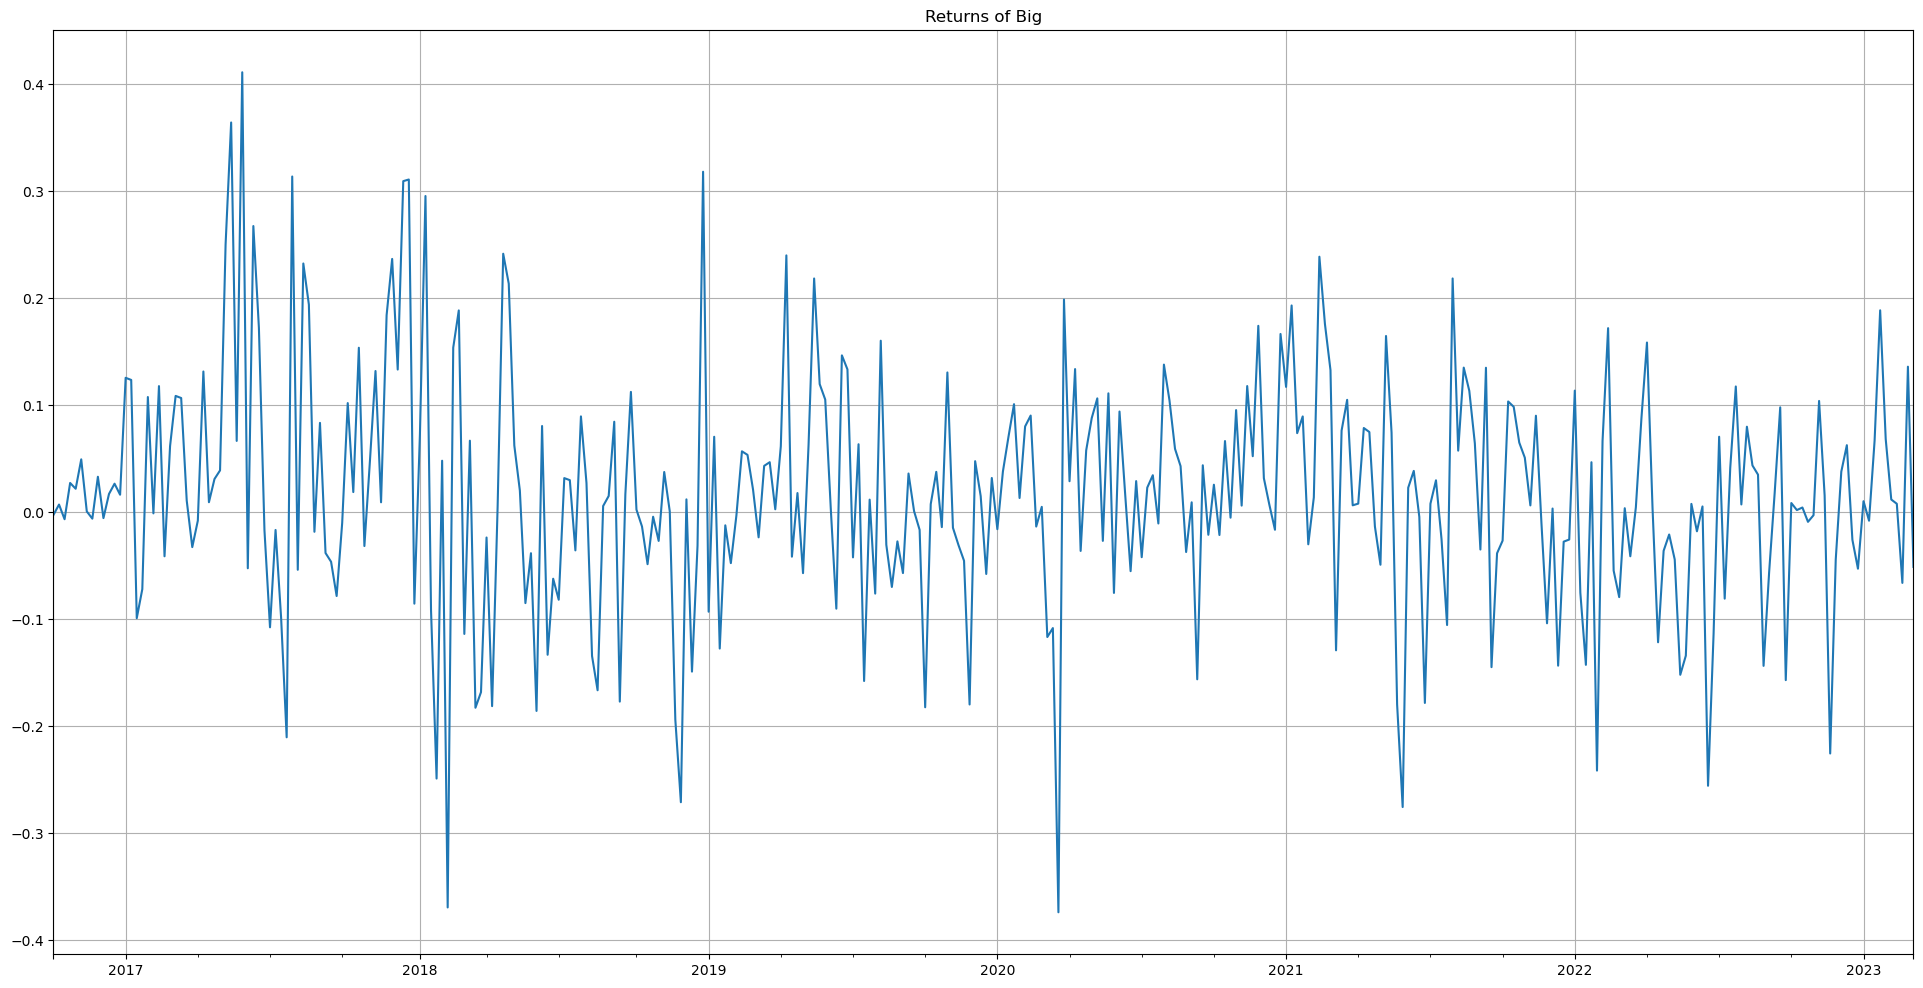

In [42]:
rtn_high.plot(figsize=(24,12))
plt.title("Returns of Big")
plt.grid();

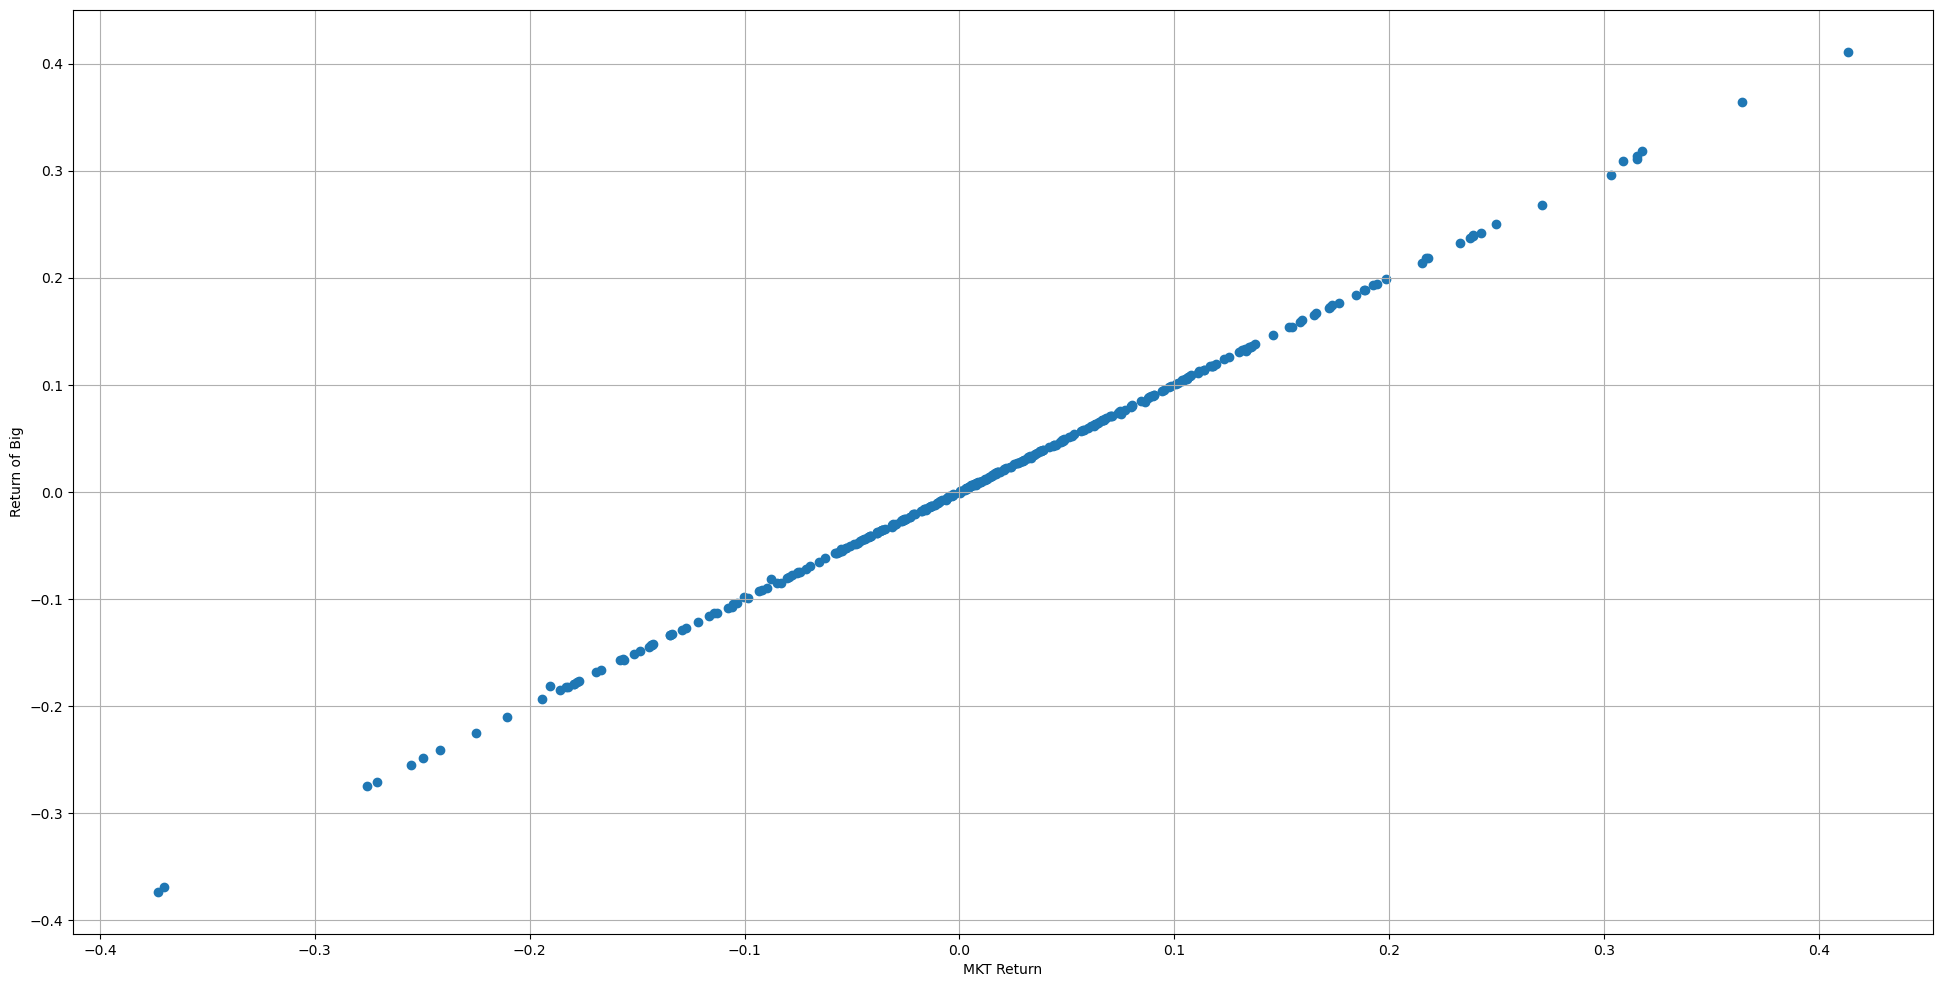

In [39]:
plt.figure(figsize=(24,12))
plt.scatter(mkt_sample,
            rtn_high)
plt.xlabel("MKT Return")
plt.ylabel("Return of Big")
plt.grid();

In [20]:
model = OLS(rtn_high, 
            add_constant(mkt_sample))

model.fit().summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:              OLS              Adj. R-squared:     1.000     
Dependent Variable: y                AIC:                -3713.0654
Date:               2023-03-17 10:02 BIC:                -3705.4312
No. Observations:   336              Log-Likelihood:     1858.5    
Df Model:           1                F-statistic:        4.525e+06 
Df Residuals:       334              Prob (F-statistic): 0.00      
R-squared:          1.000            Scale:              9.2396e-07
---------------------------------------------------------------------
            Coef.    Std.Err.       t       P>|t|     [0.025   0.975]
---------------------------------------------------------------------
const       0.0000     0.0001      0.1121   0.9108   -0.0001   0.0001
0           0.9977     0.0005   2127.2011   0.0000    0.9967   0.9986
-------------------------------------------------------------------
Omnibus:              215.386      Durbin-Watson:         1.736    
Prob(Omnibus):        0.000        Jarque-Bera (JB):      19376.062
Skew:                 1.750        Prob(JB):              0.000    
Kurtosis:             40.037       Condition No.:         9        
===================================================================

"""

In [30]:
# 리턴이 통계적으로 다름을 보이기

# weekly MKT returns의 통계량
print("Coin MKT:", mkt_rtn.mean(), mkt_rtn.std())
print("Coin MKT Sample Period:", mkt_sample.mean(), mkt_sample.std())

# 5분위로 나눈 통계량
print("Small:", rtn_small.mean().round(4), rtn_small.std(ddof=1))
print("Medium:", rtn_medium.mean().round(4), rtn_medium.std(ddof=1))
print("Big:", rtn_high.mean().round(4), rtn_high.std(ddof=1))

t, p_val = stats.ttest_ind(rtn_medium, rtn_high, equal_var=False)
t, p_val

Coin MKT: 0.015975700367382883 0.11248371663009019
Coin MKT Sample Period: 0.016820164040980988 0.11197631232808257
Small: 0.0412 0.1444976451052304
Medium: 0.021 0.14416905074110106
Big: 0.0168 0.11171918962072783


C:\Users\user\AppData\Local\Temp\ipykernel_9580\3011833931.py:12: DeprecationWarning: Please use `ttest_ind` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  t, p_val = stats.ttest_ind(rtn_medium, rtn_high, equal_var=False)


(0.4268101639296381, 0.6696632530310913)

In [31]:
def calculate_cagr(df):
    holding_year = (len(df) / 52)
    cum = (df+1).cumprod()
    cagr = (cum.iloc[-1] / cum.iloc[0]) ** (1/holding_year) -1
    print(f"The CAGR is {cagr:.2%}")
    return cagr

In [32]:
print("Market Return")
calculate_cagr(mkt_sample)

print("----------------")
print("Group Return")
calculate_cagr(rtn_small)
calculate_cagr(rtn_medium)
calculate_cagr(rtn_high)

Market Return
The CAGR is 72.56%
----------------
Group Return
The CAGR is 437.74%
The CAGR is 82.62%
The CAGR is 72.50%


0.724970228082473

In [33]:
concat_df = pd.concat([rtn_small, rtn_medium, rtn_high, mkt_sample], axis=1)
concat_df.columns = ["Small","Medium","High","MKT"]

concat_df.corr()

,Small,Medium,High,MKT
Small,1.000000,0.896379,0.748667,0.752046
Medium,0.896379,1.000000,0.829822,0.833238
High,0.748667,0.829822,1.000000,0.999963
MKT,0.752046,0.833238,0.999963,1.000000
